## Churn Analysis

In [1]:
import pandas as pd
import datetime as dt
import numpy as np

import matplotlib.pyplot as plt


In [2]:
# Load data
data = pd.read_csv('../data/online_retail_cleaned.csv')
data.shape

(406829, 9)

In [3]:
# Convert 'InvoiceDate' to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Extract returns
data_returns = data[(data['Quantity'] <= 0) | (data['UnitPrice'] <= 0)].copy()
print("Number of returns:", data_returns.shape)

# Remove returns from the dataset
data_purchases = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)].copy()
print("Number of purchases:", data_purchases.shape)

Number of returns: (8945, 9)
Number of purchases: (397884, 9)


## Compute churn and features
Churn definition: Customer who hasn't made a purchase in the last 60 days

In [4]:
# Snapshot date 
snapshot_date = data_purchases['InvoiceDate'].max() + dt.timedelta(days=1)
print("Snapshot date:", snapshot_date)

Snapshot date: 2011-12-10 12:50:00


In [5]:
# Last purchase per customer and churn calculation
last_purchase = (
    data_purchases
    .groupby('CustomerID')['InvoiceDate']
    .max()
    .reset_index()
    .rename(columns={'InvoiceDate': 'LastPurchaseDate'})
)
last_purchase['Recency'] = (snapshot_date - last_purchase['LastPurchaseDate']).dt.days
last_purchase['Churn'] = (last_purchase['Recency'] > 60).astype(int)

print("Churn rate:", last_purchase['Churn'].mean())
last_purchase.head()

Churn rate: 0.4476717381281697


,CustomerID,LastPurchaseDate,Recency,Churn
0,12346.0,2011-01-18 10:01:00,326,1
1,12347.0,2011-12-07 15:52:00,2,0
2,12348.0,2011-09-25 13:13:00,75,1
3,12349.0,2011-11-21 09:51:00,19,0
4,12350.0,2011-02-02 16:01:00,310,1


In [6]:
# Frequency (number of purchases)
frequency = data_purchases.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency.columns = ['CustomerID', 'Frequency']
frequency.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


In [7]:
# Monetary - total revenue and average spent per customer
data['Revenue'] = data['Quantity'] * data['UnitPrice']
# 1. Calculate total revenue per invoice
invoice_totals = data.groupby(['CustomerID', 'InvoiceNo'])['Revenue'].sum().reset_index()
# 2. Calculate total and average revenue per customer
monetary = invoice_totals.groupby('CustomerID')['Revenue'].agg(['sum', 'mean']).reset_index()
monetary.columns = ['CustomerID', 'TotalRevenue', 'AvgOrderValue']
monetary.head()

,CustomerID,TotalRevenue,AvgOrderValue
0,12346.0,0.00,0.000000
1,12347.0,4310.00,615.714286
2,12348.0,1797.24,449.310000
3,12349.0,1757.55,1757.550000
4,12350.0,334.40,334.400000


In [8]:
# Number of returns per customer
num_returnorders = data_returns.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
num_returnorders.columns = ['CustomerID', 'NumReturnOrders']
num_returnorders.head()

,CustomerID,NumReturnOrders
0,12346.0,1
1,12352.0,3
2,12359.0,2
3,12362.0,3
4,12365.0,1


In [9]:
# Total return value per customer
return_revenue = data_returns.groupby('CustomerID')['Revenue'].sum().reset_index()
return_revenue.columns = ['CustomerID', 'ReturnRevenue']
return_revenue['ReturnRevenue'] = return_revenue['ReturnRevenue'].abs()
return_revenue.head()

,CustomerID,ReturnRevenue
0,12346.0,77183.60
1,12352.0,960.63
2,12359.0,127.05
3,12362.0,71.65
4,12365.0,320.69


In [10]:
# Product diversity (number of unique products purchased)
product_diversity = data_purchases.groupby('CustomerID')['StockCode'].nunique().reset_index()
product_diversity.columns = ['CustomerID', 'ProductDiversity']  
product_diversity.head()

,CustomerID,ProductDiversity
0,12346.0,1
1,12347.0,103
2,12348.0,22
3,12349.0,73
4,12350.0,17


In [11]:
# Geography (Country)
country = data.groupby('CustomerID')['Country'].first().reset_index()
country.columns = ['CustomerID', 'Country']
country.head()

,CustomerID,Country
0,12346.0,United Kingdom
1,12347.0,Iceland
2,12348.0,Finland
3,12349.0,Italy
4,12350.0,Norway


In [12]:
# Merge all together
customer_features = last_purchase.merge(frequency, on='CustomerID', how='left')
customer_features = customer_features.merge(monetary, on='CustomerID', how='left')
customer_features = customer_features.merge(num_returnorders, on='CustomerID', how='left')
customer_features = customer_features.merge(return_revenue, on='CustomerID', how='left')
customer_features = customer_features.merge(product_diversity, on='CustomerID', how='left')
customer_features = customer_features.merge(country, on='CustomerID', how='left')

# Fill NaNs for customers with no returns
customer_features['NumReturnOrders'] = customer_features['NumReturnOrders'].fillna(0)
customer_features['ReturnRevenue'] = customer_features['ReturnRevenue'].fillna(0)


In [13]:
customer_features

,CustomerID,LastPurchaseDate,Recency,Churn,Frequency,TotalRevenue,AvgOrderValue,NumReturnOrders,ReturnRevenue,ProductDiversity,Country
0,12346.0,2011-01-18 10:01:00,326,1,1,0.00,0.000000,1.0,77183.60,1,United Kingdom
1,12347.0,2011-12-07 15:52:00,2,0,7,4310.00,615.714286,0.0,0.00,103,Iceland
2,12348.0,2011-09-25 13:13:00,75,1,4,1797.24,449.310000,0.0,0.00,22,Finland
3,12349.0,2011-11-21 09:51:00,19,0,1,1757.55,1757.550000,0.0,0.00,73,Italy
4,12350.0,2011-02-02 16:01:00,310,1,1,334.40,334.400000,0.0,0.00,17,Norway
...,...,...,...,...,...,...,...,...,...,...,...
4333,18280.0,2011-03-07 09:52:00,278,1,1,180.60,180.600000,0.0,0.00,10,United Kingdom
4334,18281.0,2011-06-12 10:53:00,181,1,1,80.82,80.820000,0.0,0.00,7,United Kingdom
4335,18282.0,2011-12-02 11:43:00,8,0,2,176.60,58.866667,1.0,1.45,12,United Kingdom
4336,18283.0,2011-12-06 12:02:00,4,0,16,2094.88,130.930000,0.0,0.00,263,United Kingdom


Possible additional features: 
* CustomerTenure (days from first to last purchase)
* AvgInterpurchaseTime
* ReveuePerMonth
* ReturnRate
* Trend features (e.g. last 3 months vs earlier)

## EDA

In [14]:
print("Number of samples:", len(customer_features.CustomerID))
print("Number of features:", customer_features.shape[1] - 4)  # Exclude CustomerID, Churn, Recency and LastPurchaseDate

Number of samples: 4338
Number of features: 7


In [15]:
# Define features and target variable
X = customer_features.drop(columns=['CustomerID', 'Churn', 'LastPurchaseDate', 'Recency'])
y = customer_features['Churn']

#### Check Missing values

In [16]:
# Missing values check
print("Missing values in features:\n", X.isnull().sum())

Missing values in features:
 Frequency           0
TotalRevenue        0
AvgOrderValue       0
NumReturnOrders     0
ReturnRevenue       0
ProductDiversity    0
Country             0
dtype: int64


#### Transform categorical data

In [17]:
# Check usefullness of Country feature
customer_features.groupby('Country')['Churn'].mean().sort_values(ascending=False)


Country
Bahrain                 1.000000
Brazil                  1.000000
European Community      1.000000
Czech Republic          1.000000
Canada                  1.000000
Unspecified             1.000000
United Arab Emirates    1.000000
Saudi Arabia            1.000000
Lebanon                 1.000000
Israel                  1.000000
Lithuania               1.000000
Greece                  0.750000
Australia               0.666667
Channel Islands         0.666667
Poland                  0.666667
Japan                   0.625000
Switzerland             0.600000
Cyprus                  0.571429
Austria                 0.555556
Malta                   0.500000
United Kingdom          0.447194
Netherlands             0.444444
Portugal                0.421053
Belgium                 0.416667
France                  0.402299
Germany                 0.393617
Denmark                 0.375000
Sweden                  0.375000
Spain                   0.357143
EIRE                    0.333333
No

In [18]:
# Rare-category grouping
country_counts = X['Country'].value_counts() 
rare_countries = country_counts[country_counts < 30].index

print(" Percentage of country with highest number of customers:", country_counts.iloc[0] / country_counts.sum() * 100)

# Group rare countries into 'Other' and create dummy variables
X['CountryGrouped'] = X['Country'].replace(rare_countries, 'Other')
X = pd.get_dummies(X, columns=['CountryGrouped'], drop_first=True)

 Percentage of country with highest number of customers: 90.36422314430614


#### Skewness Check

array([[<Axes: title={'center': 'Frequency'}>,
        <Axes: title={'center': 'TotalRevenue'}>],
       [<Axes: title={'center': 'AvgOrderValue'}>,
        <Axes: title={'center': 'NumReturnOrders'}>],
       [<Axes: title={'center': 'ReturnRevenue'}>,
        <Axes: title={'center': 'ProductDiversity'}>]], dtype=object)

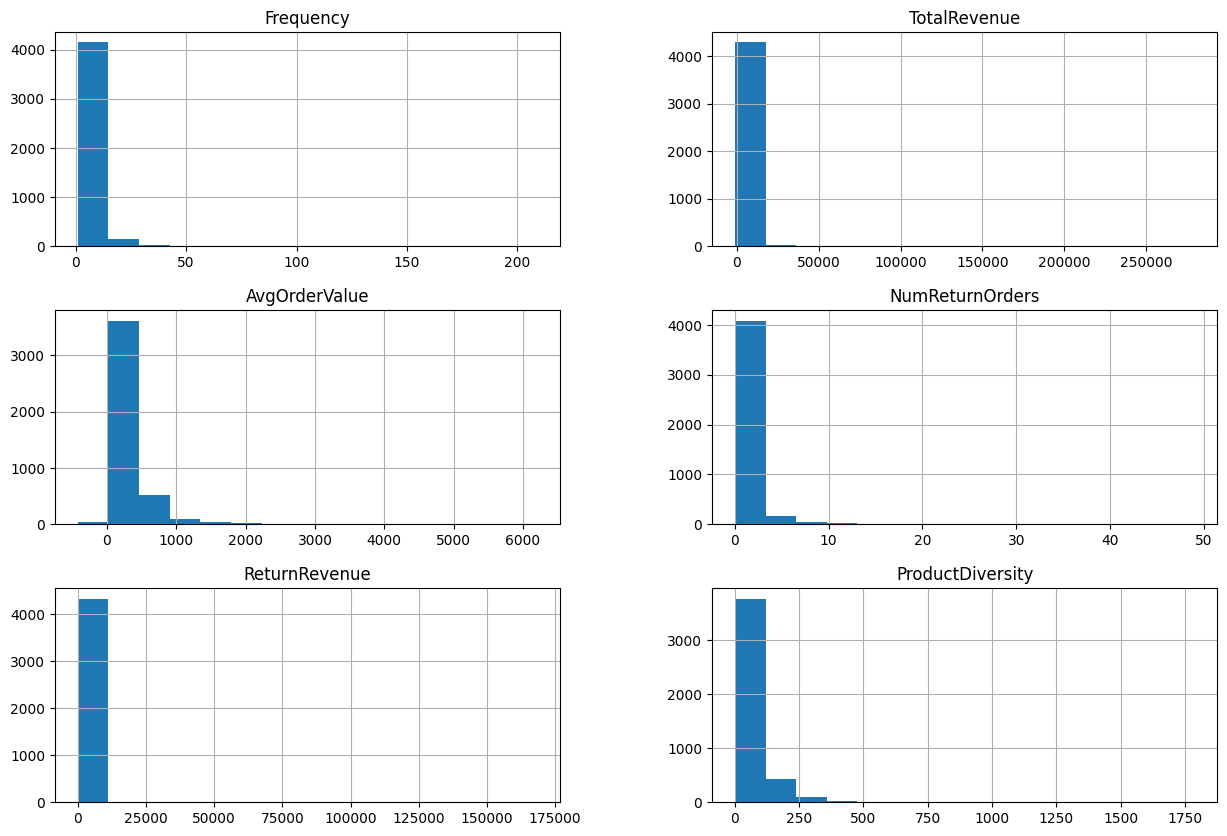

In [19]:
# Histogram of numerical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
X[numerical_features].hist(bins=15, figsize=(15, 10))

c:\Users\julia\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


array([[<Axes: title={'center': 'Frequency'}>,
        <Axes: title={'center': 'TotalRevenue'}>],
       [<Axes: title={'center': 'AvgOrderValue'}>,
        <Axes: title={'center': 'NumReturnOrders'}>],
       [<Axes: title={'center': 'ReturnRevenue'}>,
        <Axes: title={'center': 'ProductDiversity'}>]], dtype=object)

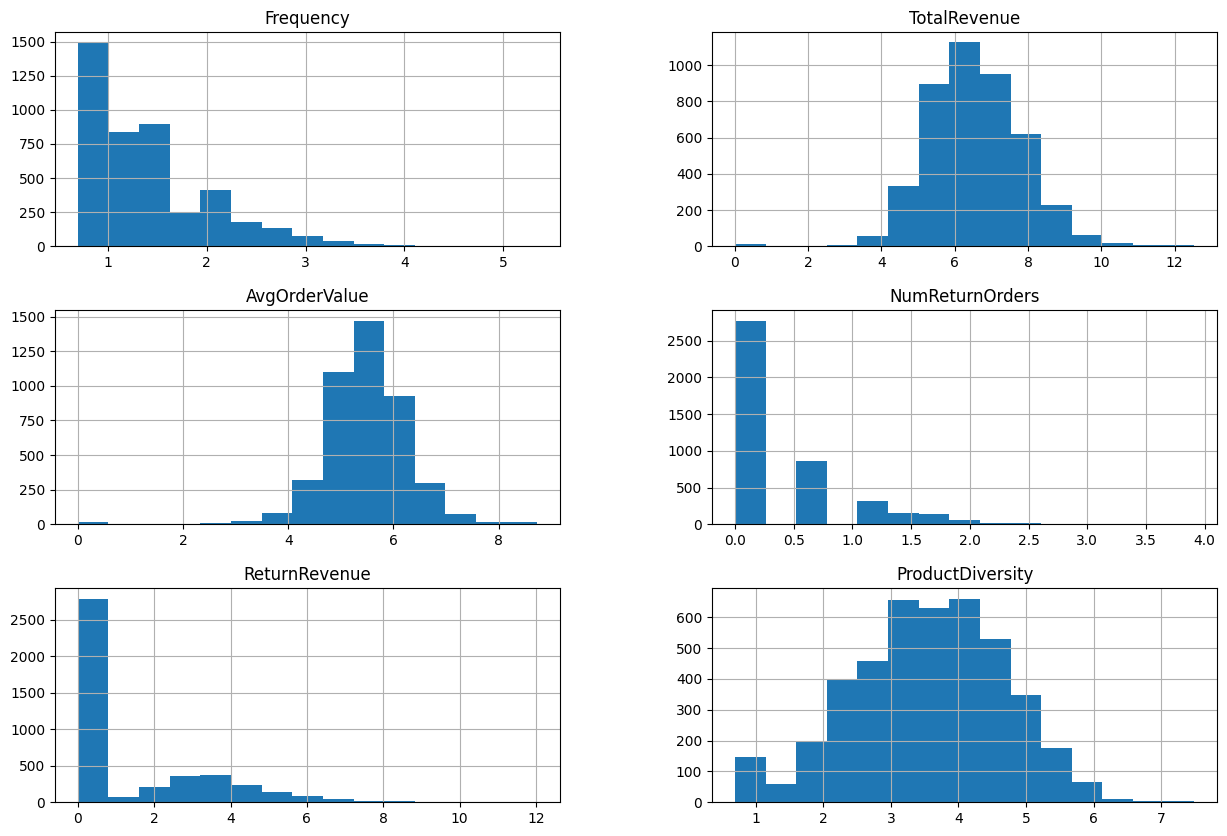

In [20]:
# Histograms of log-transformed numerical features
X_log = X.copy()
for col in numerical_features:
    X_log[col] = np.log1p(X_log[col])  # log1p to handle zero values
X_log.hist(bins=15, figsize=(15, 10))

Keep log tranformed version of TotalRevenue, AvgOrderValue, ReturnRevenue and ProductDiversity.

In [21]:
# Skewness check for numerical features
print("Skewness of features:\n", X[numerical_features].skew())

Skewness of features:
 Frequency           12.067031
TotalRevenue        21.635347
AvgOrderValue        6.669729
NumReturnOrders      8.924509
ReturnRevenue       47.271631
ProductDiversity     6.919445
dtype: float64


In [22]:
# Quantiles, 
# if 99th percentile is much higher than 95th percentile and much  higher that 90th percentile, consider capping or transforming
# extreme outliers dominate

X['NumReturnOrders'].quantile([0.5, 0.75, 0.9, 0.95, 0.99])


0.50    0.0
0.75    1.0
0.90    2.0
0.95    4.0
0.99    9.0
Name: NumReturnOrders, dtype: float64

#### Final features

In [23]:
X['TotalRevenue_log'] = np.log1p(X['TotalRevenue'])
X['AvgOrderValue_log'] = np.log1p(X['AvgOrderValue'])
X['ReturnRevenue_log'] = np.log1p(X['ReturnRevenue'])
X['ProductDiversity_log'] = np.log1p(X['ProductDiversity'])

X.drop(columns=['TotalRevenue', 'AvgOrderValue', 'ReturnRevenue', 'ProductDiversity', 'Country'], 
       inplace=True)
X.columns

selected_features = X.columns.tolist()
selected_features

c:\Users\julia\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\julia\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


['Frequency',
 'NumReturnOrders',
 'CountryGrouped_Germany',
 'CountryGrouped_Other',
 'CountryGrouped_United Kingdom',
 'TotalRevenue_log',
 'AvgOrderValue_log',
 'ReturnRevenue_log',
 'ProductDiversity_log']

## Time-based train/test split
Use 2011-09-01 as cuttoff date

In [24]:
cutoff_date = pd.Timestamp("2011-09-01")

### Recalculate temporal features with new cutoff date for training set
Only knowledge from before the cutoff date 

In [25]:
# Recalculate historical and future features based on cutoff date
data_purchases_hist = data_purchases[data_purchases['InvoiceDate'] < cutoff_date].copy()
data_purchases_future = data_purchases[data_purchases['InvoiceDate'] >= cutoff_date].copy()

data_returns_hist = data_returns[data_returns['InvoiceDate'] < cutoff_date].copy()
data_returns_future = data_returns[data_returns['InvoiceDate'] >= cutoff_date].copy()

In [26]:
data_purchases.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Revenue'],
      dtype='object')

In [27]:
# Recalculate churn based on cutoff date
last_purchase_hist = (
    data_purchases_hist
    .groupby('CustomerID')['InvoiceDate']
    .max()
    .reset_index()
    .rename(columns={'InvoiceDate': 'LastPurchaseDate'})
)
last_purchase_hist['Recency'] = (cutoff_date - last_purchase_hist['LastPurchaseDate']).dt.days
last_purchase_hist['Churn'] = (last_purchase_hist['Recency'] > 60).astype(int)

print("Churn rate:", last_purchase_hist['Churn'].mean())


Churn rate: 0.5529092553512209


In [28]:
# Recalculate features based on cutoff date
# Frequency (number of purchases)
frequency_hist = data_purchases_hist.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency_hist.columns = ['CustomerID', 'Frequency']

# Monetary - total revenue and average spent per customer
data_purchases_hist['Revenue'] = data_purchases_hist['Quantity'] * data_purchases_hist['UnitPrice']
invoice_totals_hist = data_purchases_hist.groupby(['CustomerID', 'InvoiceNo'])['Revenue'].sum().reset_index()
monetary_hist = invoice_totals_hist.groupby('CustomerID')['Revenue'].agg(['sum', 'mean']).reset_index()
# Log transform monetary features
monetary_hist['TotalRevenue_log'] = np.log1p(monetary_hist['sum'])
monetary_hist['AvgOrderValue_log'] = np.log1p(monetary_hist['mean'])
monetary_hist.columns = ['CustomerID', 'TotalRevenue', 'AvgOrderValue', 'TotalRevenue_log', 'AvgOrderValue_log']

# Number of returns per customer
num_returnorders_hist = data_returns_hist.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
num_returnorders_hist.columns = ['CustomerID', 'NumReturnOrders']

# Total return value per customer
return_revenue_hist = data_returns_hist.groupby('CustomerID')['Revenue'].sum().abs().reset_index()
# Log transform return revenue
return_revenue_hist['ReturnRevenue_log'] = np.log1p(return_revenue_hist['Revenue'])
return_revenue_hist.columns = ['CustomerID', 'ReturnRevenue', 'ReturnRevenue_log']

# Product diversity (number of unique products purchased)
product_diversity_hist = data_purchases_hist.groupby('CustomerID')['StockCode'].nunique().reset_index() 
# Log transform product diversity
product_diversity_hist['ProductDiversity_log'] = np.log1p(product_diversity_hist['StockCode'])
product_diversity_hist.columns = ['CustomerID', 'ProductDiversity', 'ProductDiversity_log']

# Geography (Country)
country_hist = data_purchases_hist.groupby('CustomerID')['Country'].first().reset_index()
country_hist.columns = ['CustomerID', 'Country']

# Merge all together
customer_features_hist = last_purchase_hist.merge(frequency_hist, on='CustomerID', how='left')
customer_features_hist = customer_features_hist.merge(monetary_hist, on='CustomerID', how='left')
customer_features_hist = customer_features_hist.merge(num_returnorders_hist, on='CustomerID', how='left')
customer_features_hist = customer_features_hist.merge(return_revenue_hist, on='CustomerID', how='left')
customer_features_hist = customer_features_hist.merge(product_diversity_hist, on='CustomerID', how='left')
customer_features_hist = customer_features_hist.merge(country_hist, on='CustomerID', how='left')
# Fill NaNs for customers with no returns
customer_features_hist['NumReturnOrders'] = customer_features_hist['NumReturnOrders'].fillna(0)
customer_features_hist['ReturnRevenue'] = customer_features_hist['ReturnRevenue'].fillna(0)

# Add CountryGrouped_United Kingdom, CountryGrouped_Germany and CountryGrouped_Other features
customer_features_hist['CountryGrouped'] = customer_features_hist['Country'].replace(rare_countries, 'Other')
customer_features_hist = pd.get_dummies(customer_features_hist, columns=['CountryGrouped'], drop_first=True)


### Define training set

In [29]:
X_train = customer_features_hist[selected_features]
y_train = customer_features_hist['Churn']

print("Number of samples in train set:", len(X_train.Frequency))
print("Number of features:", X_train.shape[1]) 
print("Selected features:", X_train.columns.tolist())   

Number of samples in train set: 3317
Number of features: 9
Selected features: ['Frequency', 'NumReturnOrders', 'CountryGrouped_Germany', 'CountryGrouped_Other', 'CountryGrouped_United Kingdom', 'TotalRevenue_log', 'AvgOrderValue_log', 'ReturnRevenue_log', 'ProductDiversity_log']


### Logistic Regression (baseline)

### Random Forest

### XGBoost

## Output

### Feature importance

### ROC curve and AUC score

### Confusion matrix

### Top churn drivers with business interpretation